In [40]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

# Set random seed for reproducibility
torch.manual_seed(42)



Using cuda device


### Using a more advanced, but still simplified dataset (approaches real life, but still not in-the-wild type dataset)


Imagenette - a section of ImageNet dataset<br>
Just 10 classes (instead of 1000) and only those considered "easy", much less images

In [42]:
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader, random_split


# https://pytorch.org/vision/main/_modules/torchvision/datasets/imagenette.html



# Define the transformations for Imagenette (ImageNet subset)
# add data augmentation from the start
# REMEMBER - those are just EXAMPLE transformations, ALWAYS know what you are doing
# in this example we are resizing the image and taking center crop to final dimmensions (discarding parts of the image on the borders)
# MORE DOCS HERE: https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html

transform = transforms.Compose([
    transforms.RandomRotation(10),  # Random rotation of up to 10 degrees
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of horizontal flip
    transforms.Resize(256), #smaller edge of the image will be matched to this number
    # transforms.CenterCrop(224),
    transforms.RandomCrop(224),  # Random crop
    # transforms.RandomCrop(227), # TECHNICALLY more historically correct, BUT 224 is more widely used
    transforms.ToTensor(),# Convert to float tensor with correct range [0.0, 1.0]; reverses order of channels (from [H, W, C] -> [C, H, W])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # values calculated from the full ImageNet dataset
                                                                                # used to be much easier to find in the docs
                                                                                # but they are still there (https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50)

])

# Normalization helps reduces the "skewness" which helps learn faster and better.
# However, to work it has to be done according to the REAL distribution, based on this specific dataset
# more info - https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/


# Load the FashionMNIST dataset
full_dataset = datasets.Imagenette(root='./data', split="train", download=False,
                                     transform=transform,
                                     size="full",
                                    #  target_transform=transforms.Lambda(lambda y: torch.nn.functional.one_hot(torch.tensor(y), num_classes=10))
                                    #  target_transform=transforms.Lambda(lambda y: torch.nn.functional.one_hot(torch.tensor(y), num_classes=10).float() * 0.9 + 0.1/10) # OR - labels smoothing (https://paperswithcode.com/method/label-smoothing)
                                     )

# Split the dataset into train and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


# Load the test dataset
test_dataset = datasets.Imagenette(root='./data', split="val", download=False, # do not redownload - it is the same file
                                     transform=transform,
                                     size="full",
                                    #  target_transform=transforms.Lambda(lambda y: torch.nn.functional.one_hot(torch.tensor(y), num_classes=10))
                                    #  target_transform=transforms.Lambda(lambda y: torch.nn.functional.one_hot(torch.tensor(y), num_classes=10).float() * 0.9 + 0.1/10) # OR - labels smoothing (https://paperswithcode.com/method/label-smoothing)
                                     )


In [43]:
# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2) # 2 is recommended for Collab
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Example of how to use the DataLoader
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Batch {batch_idx}")
    print(f"Data shape: {data.shape}")
    print(f"Target shape: {target.shape}")
    print(f"Sample target: {target[0]}")
    break

# Print dataset information
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.dataset.classes)}")

#helpers for mapping the predictions to text and vice versa
class_mapping_idx_to_name = dict(enumerate(train_dataset.dataset.classes))
print(f"Class mapping: {class_mapping_idx_to_name}")

class_mapping_name_to_idx = train_dataset.dataset.class_to_idx
print(f"Class mapping: {class_mapping_name_to_idx}")




Batch 0
Data shape: torch.Size([64, 3, 224, 224])
Target shape: torch.Size([64])
Sample target: 0
Number of training samples: 7575
Number of validation samples: 1894
Number of test samples: 3925
Number of classes: 10
Class mapping: {0: ('tench', 'Tinca tinca'), 1: ('English springer', 'English springer spaniel'), 2: ('cassette player',), 3: ('chain saw', 'chainsaw'), 4: ('church', 'church building'), 5: ('French horn', 'horn'), 6: ('garbage truck', 'dustcart'), 7: ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), 8: ('golf ball',), 9: ('parachute', 'chute')}
Class mapping: {'tench': 0, 'Tinca tinca': 0, 'English springer': 1, 'English springer spaniel': 1, 'cassette player': 2, 'chain saw': 3, 'chainsaw': 3, 'church': 4, 'church building': 4, 'French horn': 5, 'horn': 5, 'garbage truck': 6, 'dustcart': 6, 'gas pump': 7, 'gasoline pump': 7, 'petrol pump': 7, 'island dispenser': 7, 'golf ball': 8, 'parachute': 9, 'chute': 9}


In [44]:
train_dataset.dataset.classes

[('tench', 'Tinca tinca'),
 ('English springer', 'English springer spaniel'),
 ('cassette player',),
 ('chain saw', 'chainsaw'),
 ('church', 'church building'),
 ('French horn', 'horn'),
 ('garbage truck', 'dustcart'),
 ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'),
 ('golf ball',),
 ('parachute', 'chute')]

In [45]:
Imagenet_ID_to_class = {
        "n01440764": ("tench", "Tinca tinca"),
        "n02102040": ("English springer", "English springer spaniel"),
        "n02979186": ("cassette player",),
        "n03000684": ("chain saw", "chainsaw"),
        "n03028079": ("church", "church building"),
        "n03394916": ("French horn", "horn"),
        "n03417042": ("garbage truck", "dustcart"),
        "n03425413": ("gas pump", "gasoline pump", "petrol pump", "island dispenser"),
        "n03445777": ("golf ball",),
        "n03888257": ("parachute", "chute"),
    }

### Historical Architectures

Probably the first, truly succesfull CNN-based architecture was the AlexNet, described in the article: [ImageNet Classification with Deep Convolutional
 Neural Networks](https://learnopencv.com/understanding-alexnet/)
<br>
It was used in the ImageNet LSVRC-2010 and achieved state of the art results

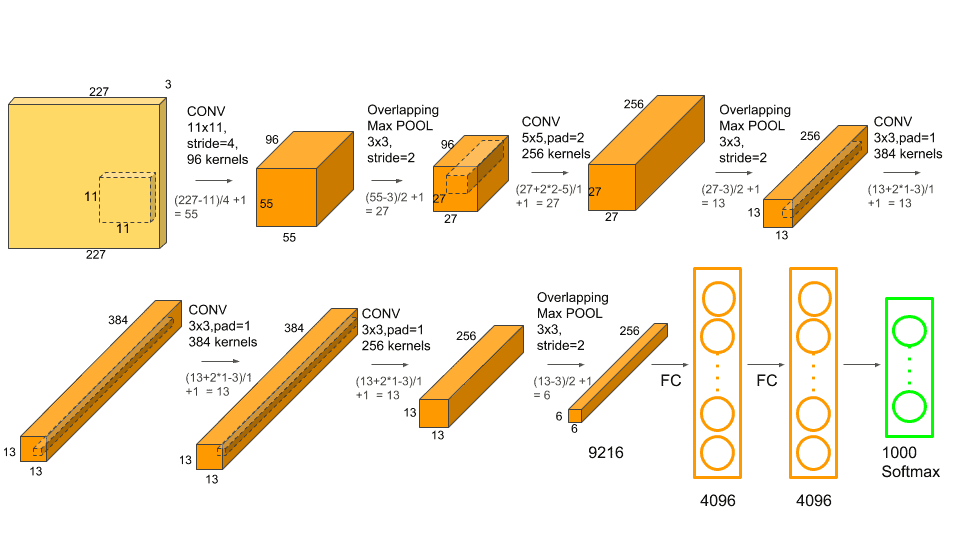

Or (to be more precise) the dual GPU version:<br>
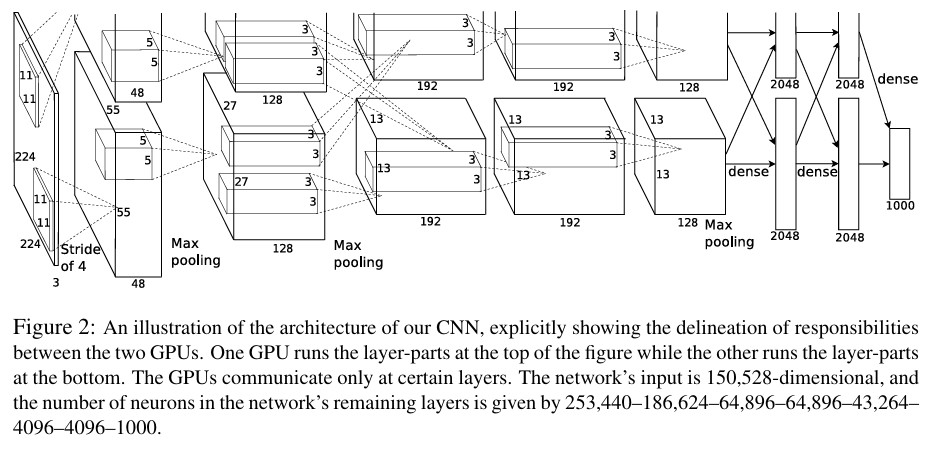

In [46]:
# simple AlexNet implementation (with some slight artistic license)

import torch
import torch.nn as nn
import torch.optim as optim

class AlexNet(nn.Module):
    def __init__(self, num_classes=10, dropout: float = 0.5 ):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,  96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



# Comment - right now AlexNet is more of an idea than concrete architecture
# For example, version in the Torchvision docs:

# class AlexNet(nn.Module):
#     def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
#         super().__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
#         self.classifier = nn.Sequential(
#             nn.Dropout(p=dropout),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=dropout),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, num_classes),
#         )

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x



### Important in the architecture

- Use of ReLU activations (previously sigmoid or tanh)

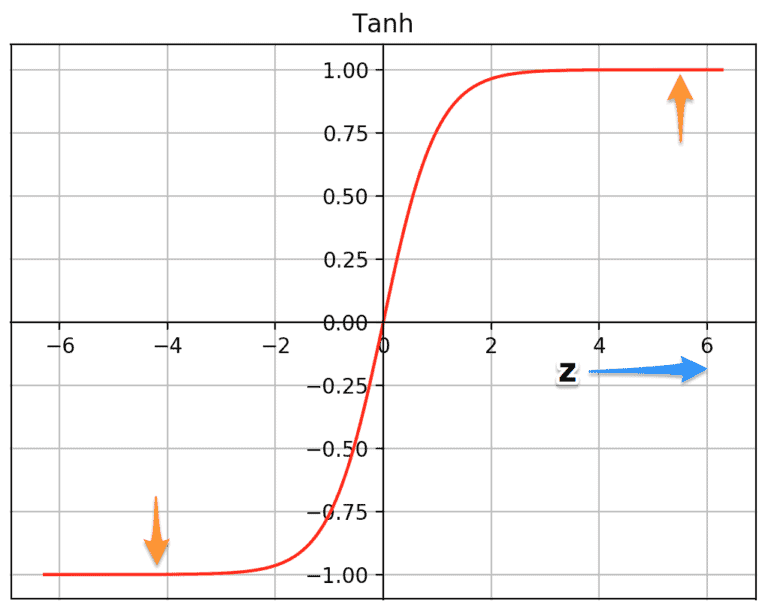

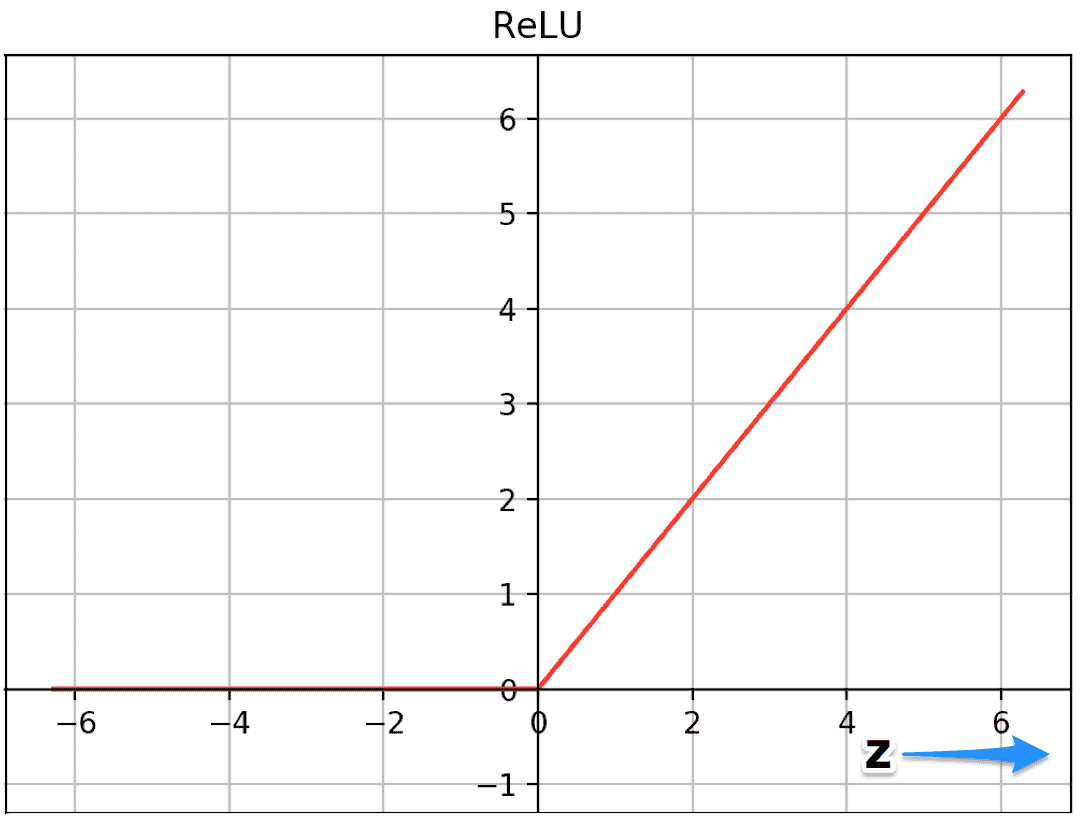
source: https://viso.ai/deep-learning/alexnet/

- Using dropout in Dense layers

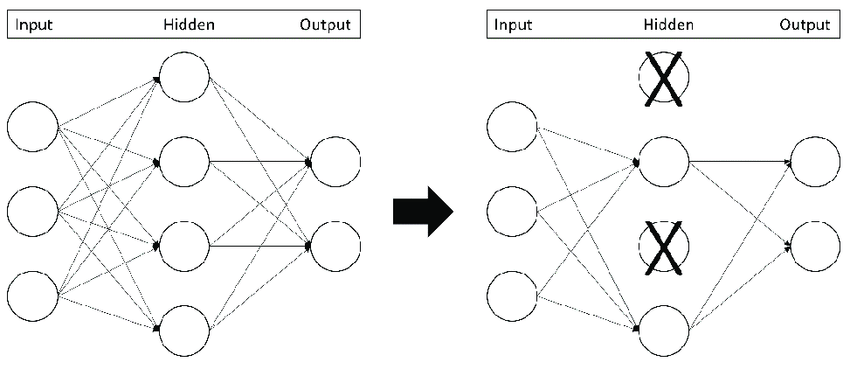
source: https://www.researchgate.net/figure/Example-of-dropout-layer-probability-of-50-appears-on-the-right_fig8_333411007


- Using overlapping Max Pooling (size 3 and stride 2; authors supposedly say it helped reduce top-1 error rate by 0.4%)



In [47]:
# Initialize the model, loss function, and optimizer
model = AlexNet(num_classes=10, dropout = 0.5).to(device)


# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = nn.CrossEntropyLoss()
# this loss computes the cross entropy loss between input logits and target.
# we have labels as integers, so the loss will apply LogSoftmax on an input,
# followed by negative log likelihood loss (NLLLoss) - IMPLICIT execution of functionality


optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10


In [48]:
# print detailed parameter information
def print_parameter_details(model):

    print(f"Model device: {next(model.parameters()).device}")

    # Print model summary
    print("Model summary: ")
    print(model)

    print("\nDetailed parameter information:")
    for name, param in model.named_parameters():
        print(f"{name}:")
        print(f"  Shape: {param.shape}")
        print(f"  Parameters: {param.numel()}")
        print(f"  Trainable: {param.requires_grad}")

    total_params = sum(param.numel() for param in model.parameters() )
    print(f"Total parameters: {total_params}")

    # Calculate the number of trainable parameters
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # https://wandb.ai/wandb_fc/tips/reports/How-To-Calculate-Number-of-Model-Parameters-for-PyTorch-and-TensorFlow-Models--VmlldzoyMDYyNzIx
    print(f"Total trainable parameters: {total_trainable_params}")


print_parameter_details(model)


Model device: cuda:0
Model summary: 
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(i

In [49]:
def train_model(device, model, train_loader, val_loader, loss_fn, optimizer, num_epochs):
    train_losses = []
    val_losses = []

    print(f"Starting Training")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            # Compute loss
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate batch loss
            train_loss += loss.item() * inputs.size(0)  # Multiply by batch size to get total loss

        # Average loss per sample
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.inference_mode():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses



In [50]:
# Test loop
def test_model(device, model, test_loader, loss_fn):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    return test_loss, test_accuracy

In [51]:
# Train the model
train_losses, val_losses = train_model(device, model, train_loader, val_loader, criterion, optimizer, num_epochs)

Starting Training
Epoch [1/10], Train Loss: 2.5038, Validation Loss: 2.3031, Validation Accuracy: 9.56%
Epoch [2/10], Train Loss: 2.3025, Validation Loss: 2.3031, Validation Accuracy: 7.81%


KeyboardInterrupt: 

In [ ]:
# Test the model
test_loss, test_accuracy = test_model(device, model, test_loader, criterion)

In [ ]:
from matplotlib import pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# ???? What is going on, can you explain the results?
# TASK - what can be done,

### Historical architectures cont.

Another big leap in CNN architectures was the VGG-16 model, introduced in 2014 ([Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556) )

This is a relatively simple architecture, but it introduced few modern paradigms, that still hold true today

Architecture configurations (from the paper):

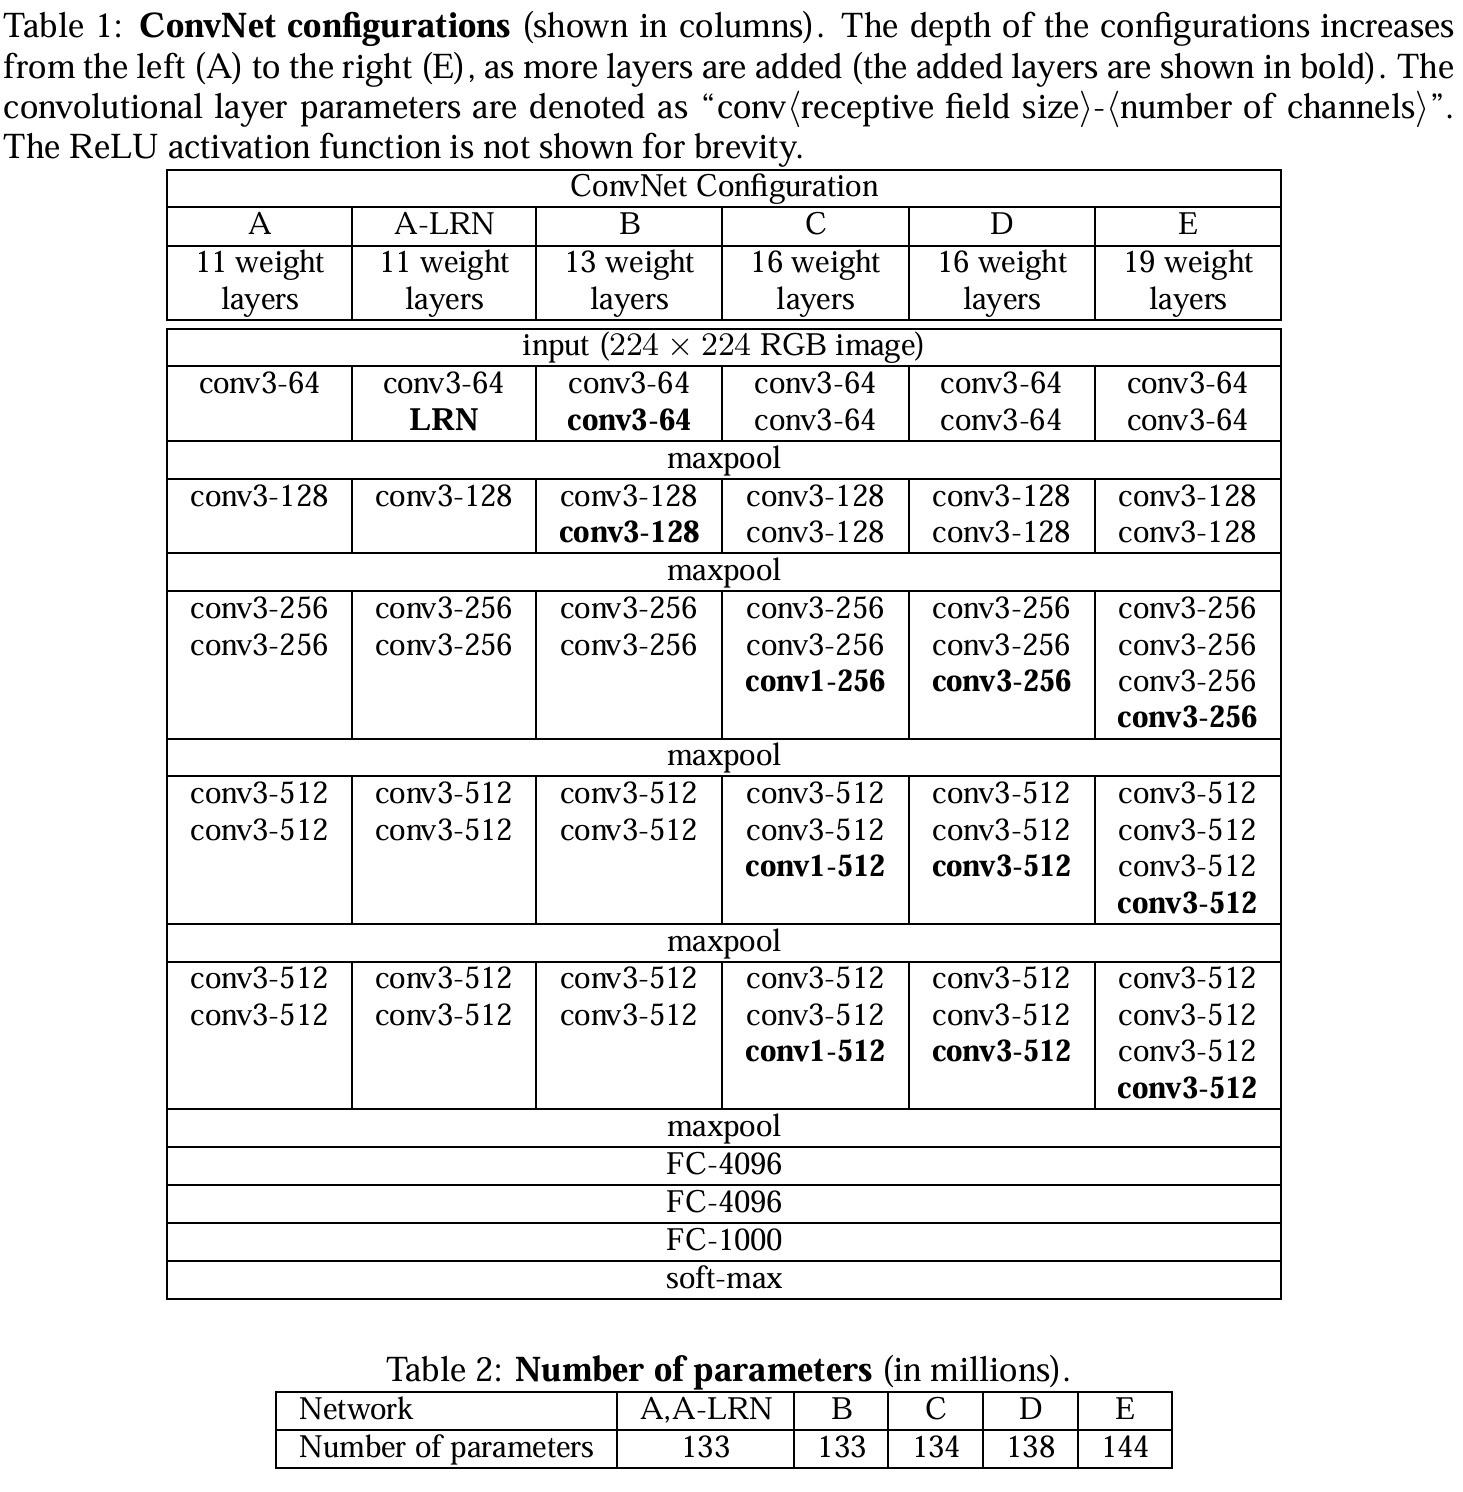

Archiecture visualization: <br>
source: https://www.geeksforgeeks.org/vgg-16-cnn-model/


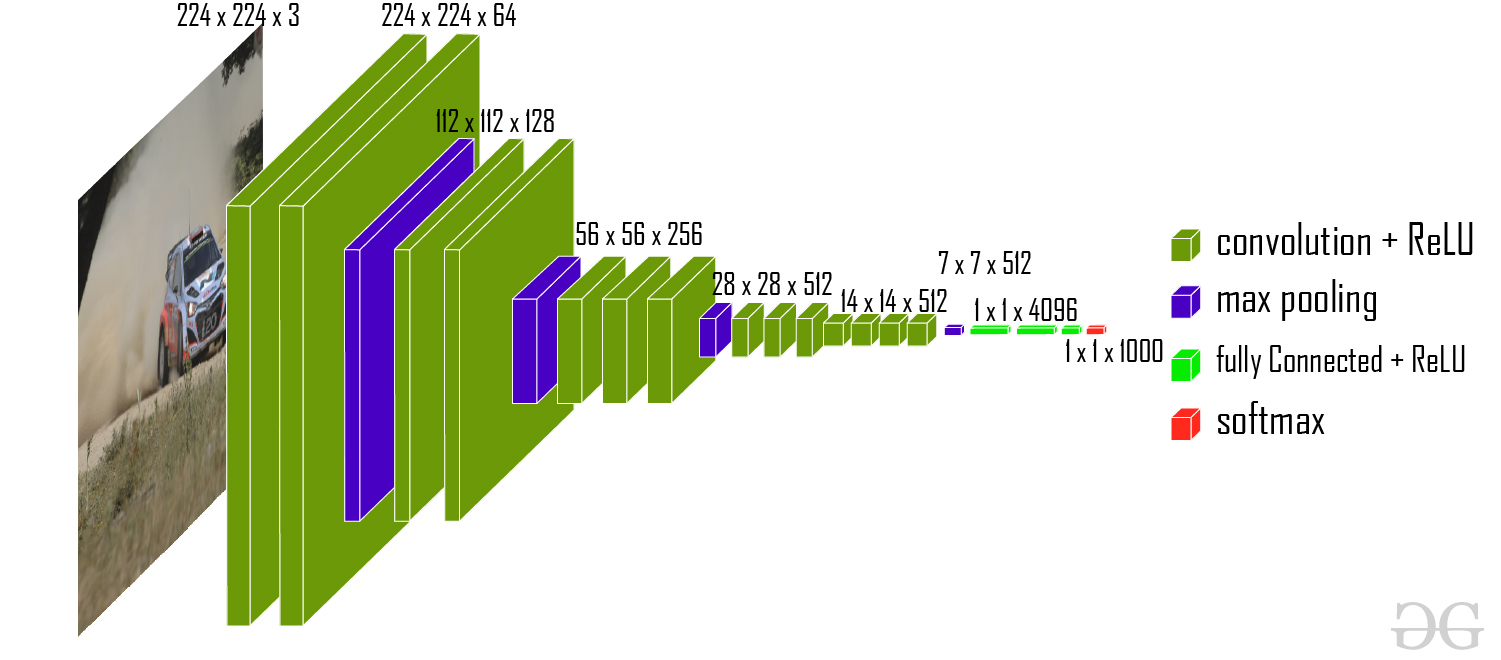

In [ ]:
# https://www.geeksforgeeks.org/vgg-16-cnn-model/

# Creating a VGG architecture model

import torch
import torch.nn as nn

class VGG16(nn.Module):
    def __init__(self, num_classes=10, init_weights=True):
        super(VGG16, self).__init__()
        # Block 1
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


In [ ]:
# print detailed parameter information
def print_parameter_details(model):

    print(f"Model device: {next(model.parameters()).device}")

    # Print model summary
    print("Model summary: ")
    print(model)

    print("\nDetailed parameter information:")
    for name, param in model.named_parameters():
        print(f"{name}:")
        print(f"  Shape: {param.shape}")
        print(f"  Parameters: {param.numel()}")
        print(f"  Trainable: {param.requires_grad}")

    total_params = sum(param.numel() for param in model.parameters() )
    print(f"Total parameters: {total_params}")

    # Calculate the number of trainable parameters
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # https://wandb.ai/wandb_fc/tips/reports/How-To-Calculate-Number-of-Model-Parameters-for-PyTorch-and-TensorFlow-Models--VmlldzoyMDYyNzIx
    print(f"Total trainable parameters: {total_trainable_params}")

In [ ]:
def train_model(device, model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []

    print(f"Starting Training")
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate batch loss (not divided by dataset size)
            running_loss += loss.item()

            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            # Print progress every 50 batches
            if batch_idx % 50 == 0:
                print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item():.4f}')

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)  # Average loss per batch
        train_accuracy = 100. * train_correct / train_total
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.inference_mode():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader)
        val_accuracy = 100. * val_correct / val_total
        val_losses.append(val_epoch_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        print('-' * 60)

    return train_losses, val_losses

In [ ]:
# Test loop
def test_model(device, model, test_loader, loss_fn):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    return test_loss, test_accuracy

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

# Set random seed for reproducibility
torch.manual_seed(42)


model = VGG16(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4) # https://paperswithcode.com/method/weight-decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True) # https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

num_epochs = 10


In [ ]:
print_parameter_details(model)

In [ ]:
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader, random_split


# https://pytorch.org/vision/main/_modules/torchvision/datasets/imagenette.html



# Define the transformations for Imagenette (ImageNet subset)
# add data augmentation from the start
# REMEMBER - those are just EXAMPLE transformations, ALWAYS know what you are doing
# in this example we are resizing the image and taking center crop to final dimmensions (discarding parts of the image on the borders)
# MORE DOCS HERE: https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html

transform = transforms.Compose([
    transforms.RandomRotation(10),  # Random rotation of up to 10 degrees
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of horizontal flip
    transforms.Resize(256), #smaller edge of the image will be matched to this number
    # transforms.CenterCrop(224),
    transforms.RandomCrop(224),  # Random crop
    # transforms.RandomCrop(227), # TECHNICALLY more historically correct, BUT 224 is more widely used
    transforms.ToTensor(),# Convert to float tensor with correct range [0.0, 1.0]; reverses order of channels (from [H, W, C] -> [C, H, W])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # values calculated from the full ImageNet dataset
                                                                                # used to be much easier to find in the docs
                                                                                # but they are still there (https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50)

])

# Normalization helps reduces the "skewness" which helps learn faster and better.
# However, to work it has to be done according to the REAL distribution, based on this specific dataset
# more info - https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/


# Load the FashionMNIST dataset
full_dataset = datasets.Imagenette(root='./data', split="train", download=True,
                                     transform=transform,
                                     size="full",
                                    #  target_transform=transforms.Lambda(lambda y: torch.nn.functional.one_hot(torch.tensor(y), num_classes=10))
                                    #  target_transform=transforms.Lambda(lambda y: torch.nn.functional.one_hot(torch.tensor(y), num_classes=10).float() * 0.9 + 0.1/10) # OR - labels smoothing (https://paperswithcode.com/method/label-smoothing)
                                     )

# Split the dataset into train and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


# Load the test dataset
test_dataset = datasets.Imagenette(root='./data', split="val", download=False, # do not redownload - it is the same file
                                     transform=transform,
                                     size="full",
                                    #  target_transform=transforms.Lambda(lambda y: torch.nn.functional.one_hot(torch.tensor(y), num_classes=10))
                                    #  target_transform=transforms.Lambda(lambda y: torch.nn.functional.one_hot(torch.tensor(y), num_classes=10).float() * 0.9 + 0.1/10) # OR - labels smoothing (https://paperswithcode.com/method/label-smoothing)
                                     )


In [ ]:
# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2) # 2 is recommended for Collab
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Example of how to use the DataLoader
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Batch {batch_idx}")
    print(f"Data shape: {data.shape}")
    print(f"Target shape: {target.shape}")
    print(f"Sample target: {target[0]}")
    break

# Print dataset information
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.dataset.classes)}")

#helpers for mapping the predictions to text and vice versa
class_mapping_idx_to_name = dict(enumerate(train_dataset.dataset.classes))
print(f"Class mapping: {class_mapping_idx_to_name}")

class_mapping_name_to_idx = train_dataset.dataset.class_to_idx
print(f"Class mapping: {class_mapping_name_to_idx}")


In [ ]:
train_losses, val_losses = train_model(device, model, train_loader, val_loader, criterion, optimizer, num_epochs)

In [ ]:
# Test the model
test_loss, test_accuracy = test_model(device, model, test_loader, criterion)

In [ ]:
from matplotlib import pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Transfering knowledge

Sometimes it is not necessary to do the same work from the beginning each time.

Training a deep learning model from scratch can be a daunting task, often requiring massive datasets and significant computational resources. It would be much easier to just "transfer knowledge" from someone, that has olready done similiar (if not exactly same) thing.

For this exact purpose an approach called transfer learning was created. It offers a more efficient and effective approach by leveraging pre-trained models. These models, trained on large datasets like ImageNet, have learned to recognize complex patterns and features.

In order to start we need a model, that is good at something, that has the architecture we want. In pytorch there are already few models we can use. As we know how a VGG architecture works, we can use it



In [ ]:
import torchvision.models as models
from torchvision.models import vgg16, VGG16_Weights

# Load pretrained VGG16
pretrained_vgg = models.vgg16(weights='VGG16_Weights.DEFAULT') # OR
# pretrained_vgg = models.vgg16(weights= VGG16_Weights.DEFAULT) # other option: VGG16_Weights.IMAGENET1K_V1 - read the docs



In [ ]:
print_parameter_details(pretrained_vgg)

In [ ]:
# TASK for end of classes
# use the pretrained model to check if it can work on the Imaginette dataset
# use the model to recognize your own, imported image
# remember to read the docs and understand your actions
# https://pytorch.org/vision/stable/models.html



In [ ]:
# Create our model
model = VGG16(num_classes=10).to(device)

# Copy features (convolutional layers)
model.features.load_state_dict(pretrained_vgg.features.state_dict())

# We can copy only part of our weights - the "classifier" part has different dimmensions
# we have to train them from scratch, we will however try to not lose the information already in the network

In [ ]:
def prepare_model_for_training(model, freeze_features=True):
    """
    Prepare the model for training by freezing/unfreezing appropriate layers
    """
    # Freeze the features (convolutional layers)
    if freeze_features:
        for param in model.features.parameters():
            param.requires_grad = False

    # Ensure classifier layers are unfrozen
    for param in model.classifier.parameters():
        param.requires_grad = True

    return model

In [ ]:
# Prepare model for training (freeze/unfreeze layers)
model = prepare_model_for_training(model, freeze_features=True)


optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                          lr=0.001) # we will try with simple parameters first
criterion = nn.CrossEntropyLoss()

num_epochs = 10

print_parameter_details(model)

In [ ]:
train_losses, val_losses = train_model(device, model, train_loader, val_loader, criterion, optimizer, num_epochs)

In [ ]:
# Test the model
test_loss, test_accuracy = test_model(device, model, test_loader, criterion)

In [ ]:
from matplotlib import pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# after training it is a good idea to fine-tune the model by unfreezing the layers and letting it fully train
# TASK - unfreeze the layers and train the model for few more epochs. '
# do it by modifying the "prepare_model(...)" function to be more flexible



### Modifying the convolutions

Movie time:<br>
[Animated AI: Groups, Depthwise, and Depthwise-Separable Convolution (Neural Networks)](https://www.youtube.com/watch?v=vVaRhZXovbw)

In [ ]:
# convolutions in groups
import torch
import torch.nn as nn
import torch.nn.functional as F

# Create a sample input tensor [batch_size, channels, height, width]
batch_size = 1
in_channels = 4
height = 28
width = 28
input_tensor = torch.randn(batch_size, in_channels, height, width)


In [ ]:
# Example 1: Regular convolution (groups=1)
regular_conv = nn.Conv2d(
    in_channels=4,
    out_channels=8,
    kernel_size=3,
    padding=1,
    groups=1
)
regular_output = regular_conv(input_tensor)
print("\nRegular Convolution:")
print(f"Input shape: {input_tensor.shape}")
print(f"Output shape: {regular_output.shape}")
print(f"Number of parameters: {sum(p.numel() for p in regular_conv.parameters())}")


In [ ]:
# Example 2: Grouped convolution (groups=2)
grouped_conv = nn.Conv2d(
    in_channels=4,
    out_channels=8,
    kernel_size=3,
    padding=1,
    groups=2  # Split into 2 groups
)
grouped_output = grouped_conv(input_tensor)
print("\nGrouped Convolution (groups=2):")
print(f"Input shape: {input_tensor.shape}")
print(f"Output shape: {grouped_output.shape}")
print(f"Number of parameters: {sum(p.numel() for p in grouped_conv.parameters())}")


In [6]:
# Example 3: Depthwise convolution (groups=in_channels)
depthwise_conv = nn.Conv2d(
    in_channels=4,
    out_channels=4,
    kernel_size=3,
    padding=1,
    groups=4  # Each input channel is convolved separately
)
depthwise_output = depthwise_conv(input_tensor)
print("\nDepthwise Convolution (groups=in_channels):")
print(f"Input shape: {input_tensor.shape}")
print(f"Output shape: {depthwise_output.shape}")
print(f"Number of parameters: {sum(p.numel() for p in depthwise_conv.parameters())}")


NameError: name 'nn' is not defined

In [ ]:
# Visual explanation of how the channels are grouped
print("\nChannel grouping explanation:")
print("Regular Conv (groups=1):")
print("Input channels [0,1,2,3] -> All output channels can see all input channels")

print("\nGrouped Conv (groups=2):")
print("Input channels [0,1] -> Output channels [0,1,2,3]")
print("Input channels [2,3] -> Output channels [4,5,6,7]")

print("\nDepthwise Conv (groups=4):")
print("Input channel [0] -> Output channel [0]")
print("Input channel [1] -> Output channel [1]")
print("Input channel [2] -> Output channel [2]")
print("Input channel [3] -> Output channel [3]")

# Demonstrate parameter reduction
params_regular = regular_conv.weight.numel() + regular_conv.bias.numel()
params_grouped = grouped_conv.weight.numel() + grouped_conv.bias.numel()
params_depthwise = depthwise_conv.weight.numel() + depthwise_conv.bias.numel()

print("\nParameter comparison:")
print(f"Regular conv parameters: {params_regular}")
print(f"Grouped conv parameters: {params_grouped}")
print(f"Depthwise conv parameters: {params_depthwise}")
print(f"Reduction from regular to grouped: {(1 - params_grouped/params_regular)*100:.1f}%")
print(f"Reduction from regular to depthwise: {(1 - params_depthwise/params_regular)*100:.1f}%")

In [ ]:
# 1x1 convolutions (sometimes called network-in-network)

import torch
import torch.nn as nn
import torch.nn.functional as F

# Create a sample input tensor [batch_size, channels, height, width]
batch_size = 1
in_channels = 64
height = 28
width = 28
input_tensor = torch.randn(batch_size, in_channels, height, width)


In [ ]:
# Example 1: Channel reduction with 1x1 conv
channel_reduction = nn.Conv2d(
    in_channels=64,
    out_channels=32,
    kernel_size=1  # 1x1 convolution
)
reduced_output = channel_reduction(input_tensor)
print("\nChannel Reduction with 1x1 Conv:")
print(f"Input shape: {input_tensor.shape}")
print(f"Output shape: {reduced_output.shape}")
print(f"Parameters: {sum(p.numel() for p in channel_reduction.parameters())}")




In [ ]:
# Example 2: Channel expansion with 1x1 conv
channel_expansion = nn.Conv2d(
    in_channels=64,
    out_channels=128,
    kernel_size=1
)
expanded_output = channel_expansion(input_tensor)
print("\nChannel Expansion with 1x1 Conv:")
print(f"Input shape: {input_tensor.shape}")
print(f"Output shape: {expanded_output.shape}")
print(f"Parameters: {sum(p.numel() for p in channel_expansion.parameters())}")


In [ ]:
# Example 3: 1x1 conv with groups
grouped_1x1 = nn.Conv2d(
    in_channels=64,
    out_channels=64,
    kernel_size=1,
    groups=4  # Split into 4 groups
)
grouped_output = grouped_1x1(input_tensor)
print("\n1x1 Conv with Groups:")
print(f"Input shape: {input_tensor.shape}")
print(f"Output shape: {grouped_output.shape}")
print(f"Parameters: {sum(p.numel() for p in grouped_1x1.parameters())}")



In [ ]:

# Visual explanation of what 1x1 convolutions do
# What 1x1 convolutions actually do
# They're equivalent to fully connected layers applied at each spatial location (network in network)
# They can't mix spatial information (have no receptive field)
# They're commonly used for:
# - Channel reduction/expansion
# - Adding nonlinearity between layers
# - Cross-channel interaction


# Comparison with standard 3x3 conv
standard_3x3 = nn.Conv2d(
    in_channels=64,
    out_channels=64,
    kernel_size=3,
    padding=1
)
standard_output = standard_3x3(input_tensor)

# Parameter comparison
params_1x1_reduction = channel_reduction.weight.numel() + channel_reduction.bias.numel()
params_1x1_expansion = channel_expansion.weight.numel() + channel_expansion.bias.numel()
params_3x3 = standard_3x3.weight.numel() + standard_3x3.bias.numel()

print("\nParameter comparison:")
print(f"3x3 conv (64->64): {params_3x3}")
print(f"1x1 conv (64->32): {params_1x1_reduction}")
print(f"1x1 conv (64->128): {params_1x1_expansion}")

# Example of combining 1x1 with 3x3 (as in bottleneck designs)
print("\nBottleneck example:")
bottleneck = nn.Sequential(
    # Reduce channels
    nn.Conv2d(64, 32, kernel_size=1),
    nn.ReLU(),
    # Process spatial information
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    # Expand channels
    nn.Conv2d(32, 128, kernel_size=1)
)
bottleneck_output = bottleneck(input_tensor)
print(f"Input shape: {input_tensor.shape}")
print(f"Output shape: {bottleneck_output.shape}")
print(f"Total parameters: {sum(p.numel() for p in bottleneck.parameters())}")

In [ ]:
# TASK 1
# Create your own architecture for Imaginette dataset
# It can be inspired by any architecture you already know (cannot use transfer learning)
# It HAS to use "depthwise separable convolutions"
#
# Modify the training loop in such a way, that it will save the best model (define and explain what that means in the comments)
# to disk (and ONLY the best model)

import torch
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

torch.manual_seed(42)

transform = v2.Compose([
    v2.RandomRotation(10),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Resize((224,224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.Resize((224,224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

full_dataset = datasets.Imagenette(root='./data', split="train", download=False,
                                     transform=transform,
                                     size="full",
                                     )

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

test_dataset = datasets.Imagenette(root='./data', split="val", download=False,
                                   transform=test_transform,
                                     size="full",
                                     )

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.dataset.classes)}")

Using cuda device
Number of training samples: 7575
Number of validation samples: 1894
Number of test samples: 3925
Number of classes: 10


c:\Users\Dominik\anaconda3\envs\cuda_env\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [63]:
class_mapping_name_to_idx = train_dataset.dataset.class_to_idx
print(f"Class mapping: {class_mapping_name_to_idx}")

Class mapping: {'tench': 0, 'Tinca tinca': 0, 'English springer': 1, 'English springer spaniel': 1, 'cassette player': 2, 'chain saw': 3, 'chainsaw': 3, 'church': 4, 'church building': 4, 'French horn': 5, 'horn': 5, 'garbage truck': 6, 'dustcart': 6, 'gas pump': 7, 'gasoline pump': 7, 'petrol pump': 7, 'island dispenser': 7, 'golf ball': 8, 'parachute': 9, 'chute': 9}


In [ ]:
import einops
import torch.nn as nn

class ImaginetteCNN(nn.Module):

    @staticmethod
    def depthwise_separable_conv(in_channels, out_channels, kernel_size=3, stride=1, padding=1, dropout_p=0.2):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
        )

    def __init__(self, num_classes=10, **kwargs):
        super().__init__()

        self.features = nn.Sequential(
            # Entry flow
            nn.Conv2d(3, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            ImaginetteCNN.depthwise_separable_conv(64, 128),
            nn.ReLU(),           
            ImaginetteCNN.depthwise_separable_conv(128, 128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            ImaginetteCNN.depthwise_separable_conv(128, 256),
            nn.ReLU(),           
            ImaginetteCNN.depthwise_separable_conv(256, 256),
            nn.ReLU(),
            ImaginetteCNN.depthwise_separable_conv(256, 256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Middle flow
            ImaginetteCNN.depthwise_separable_conv(256, 256),
            nn.ReLU(),           
            ImaginetteCNN.depthwise_separable_conv(256, 256),
            nn.ReLU(),
            ImaginetteCNN.depthwise_separable_conv(256, 256),
            nn.ReLU(),
            ImaginetteCNN.depthwise_separable_conv(256, 256),
            nn.ReLU(),

            # Exit flow
            ImaginetteCNN.depthwise_separable_conv(256, 512),
            nn.ReLU(),
            ImaginetteCNN.depthwise_separable_conv(512, 1024),
            nn.ReLU(),
            ImaginetteCNN.depthwise_separable_conv(1024, 1024),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d((1,1))
        )

        self.classifier = nn.Sequential(
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=2048, out_features=num_classes)
        )

    def forward(self, x): 
        x = self.features(x)
        x = einops.rearrange(x, "b c w h -> b (c w h)")
        x = self.classifier(x)
        return x
        

In [ ]:
import torch.optim as optim
import os

def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, save_path='best_model_1.pth'):
    train_losses = []
    val_losses = []
    best_val_accuracy = 0.0
    print(f"Starting Training")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            # labels = class_mapping_name_to_idx[labels]
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                # print(f'Labels:\n{labels}')
                # labels = class_mapping_name_to_idx[labels]
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs.data, 1)
                # print(f'\nPredicted:\n{predicted}')
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.2f}%')
        
        # scheduler.step(val_loss)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f'Best model saved with Validation Accuracy: {best_val_accuracy:.2f}%')
        
    return train_losses, val_losses


def test_model(model, test_loader, loss_fn):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    return test_loss, test_accuracy

In [169]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [170]:
num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 1e-3

model = ImaginetteCNN(num_classes)
model.apply(init_weights)
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [171]:
train_losses, val_losses = train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs)

Starting Training
Epoch [1/20], Train Loss: 5.0299, Validation Loss: 1.8990, Validation Accuracy: 33.90%
Epoch [2/20], Train Loss: 1.9874, Validation Loss: 1.7681, Validation Accuracy: 39.76%
Epoch [3/20], Train Loss: 1.8790, Validation Loss: 1.7405, Validation Accuracy: 39.65%
Epoch [4/20], Train Loss: 1.7738, Validation Loss: 1.5572, Validation Accuracy: 46.46%
Epoch [5/20], Train Loss: 1.6563, Validation Loss: 1.4688, Validation Accuracy: 49.47%
Epoch [6/20], Train Loss: 1.5367, Validation Loss: 1.3347, Validation Accuracy: 55.33%
Epoch [7/20], Train Loss: 1.4312, Validation Loss: 1.3218, Validation Accuracy: 56.07%
Epoch [8/20], Train Loss: 1.3348, Validation Loss: 1.2916, Validation Accuracy: 56.18%
Epoch [9/20], Train Loss: 1.2121, Validation Loss: 1.1851, Validation Accuracy: 62.20%
Epoch [10/20], Train Loss: 1.1037, Validation Loss: 1.0196, Validation Accuracy: 67.74%
Epoch [11/20], Train Loss: 1.0284, Validation Loss: 1.0501, Validation Accuracy: 67.48%
Epoch [12/20], Train Lo

In [172]:
test_loss, test_accuracy = test_model(model, test_loader, loss_fn)

Test Loss: 0.6173, Test Accuracy: 80.84%


In [ ]:
from matplotlib import pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
!kaggle datasets download -d sautkin/imagenet1k0

In [ ]:
!kaggle datasets download -d sautkin/imagenet1k1

In [ ]:
!kaggle datasets download -d sautkin/imagenet1kvalid

In [38]:
# TASK 2
# using Kaggle read the ImageNet-1k dataset
#   https://www.kaggle.com/datasets/sautkin/imagenet1k0
#   https://www.kaggle.com/datasets/sautkin/imagenet1k1
#   https://www.kaggle.com/datasets/sautkin/imagenet1k2
#   https://www.kaggle.com/datasets/sautkin/imagenet1k3
#   https://www.kaggle.com/datasets/sautkin/imagenet1kvalid
#
# You can also use:
#   https://www.kaggle.com/datasets/deeptrial/miniimagenet (has class mapping JSON)
#   https://www.kaggle.com/datasets/vitaliykinakh/stable-imagenet1k - synthetic dataset; class mapping in the folder names
#

# create datasets and data loaders for the model
# create a training and testing loop for the
# train a VGG inpired model on this dataset (you can use transfer learning)
# save the best model
# test it on the validation set AND/OR the synthetic dataset

import torch
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import os

transform = v2.Compose([
    v2.RandomRotation(10),
    v2.RandomHorizontalFlip(),
    v2.Resize((224, 224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root='./ImageNetDS', transform=transform)
val_dataset = ImageFolder(root='./ImageNetDSValid', transform=test_transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {train_dataset.classes}")


c:\Users\Dominik\anaconda3\envs\cuda_env\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Number of classes: 1000
Classes: ['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042', '00043', '00044', '00045', '00046', '00047', '00048', '00049', '00050', '00051', '00052', '00053', '00054', '00055', '00056', '00057', '00058', '00059', '00060', '00061', '00062', '00063', '00064', '00065', '00066', '00067', '00068', '00069', '00070', '00071', '00072', '00073', '00074', '00075', '00076', '00077', '00078', '00079', '00080', '00081', '00082', '00083', '00084', '00085', '00086', '00087', '00088', '00089', '00090', '00091', '00092', '00093', '00094', '00095', '00096', '00097', '00098', '00099', '00100', '00101', '00102', '00103', '00104', '00105', '00106', '00

In [43]:
import torch.optim as optim
import os

def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, save_path='best_model_1.pth'):
    train_losses = []
    val_losses = []
    best_val_accuracy = 0.0
    print(f"Starting Training")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            # print(labels)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        print(f'Train loss: {train_loss}')
        with torch.no_grad():
            for inputs, labels in val_loader:
                # print(f'Actual: {labels}\n')
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs.data, 1)
                # print(f'Predicted: {predicted}\n')
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.2f}%')
        

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f'Best model saved with Validation Accuracy: {best_val_accuracy:.2f}%')
        
    return train_losses, val_losses


def test_model(model, test_loader, loss_fn):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    return test_loss, test_accuracy

In [44]:
def print_parameter_details(model):

    print(f"Model device: {next(model.parameters()).device}")

    print("Model summary: ")
    print(model)

    print("\nDetailed parameter information:")
    for name, param in model.named_parameters():
        print(f"{name}:")
        print(f"  Shape: {param.shape}")
        print(f"  Parameters: {param.numel()}")
        print(f"  Trainable: {param.requires_grad}")

    total_params = sum(param.numel() for param in model.parameters() )
    print(f"Total parameters: {total_params}")

    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_trainable_params}")

In [47]:
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights

num_epochs = 5
learning_rate = 1e-3

model = models.vgg16(weights='VGG16_Weights.DEFAULT')

for param in model.features.parameters():
    param.requires_grad = False

for layer in model.classifier[:-1]:
    for param in layer.parameters():
        param.requires_grad = False

model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3)

print_parameter_details(model)

Model device: cuda:0
Model summary: 
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_si

In [48]:
train_losses, val_losses = train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs)

Starting Training
Train loss: 2.68279064740312
Epoch [1/5], Train Loss: 2.6828, Validation Loss: 2.7827, Validation Accuracy: 63.85%
Best model saved with Validation Accuracy: 63.85%
Train loss: 2.9827536480266827
Epoch [2/5], Train Loss: 2.9828, Validation Loss: 3.1462, Validation Accuracy: 65.10%
Best model saved with Validation Accuracy: 65.10%


KeyboardInterrupt: 

In [52]:
model = models.vgg16()
model.load_state_dict(torch.load('best_model_1.pth'))
model.to(device)

model.eval()
test_loss, test_accuracy = test_model(model, val_loader, loss_fn)

C:\Users\Dominik\AppData\Local\Temp\ipykernel_16160\3537817819.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_1.pth'))


Test Loss: 3.1462, Test Accuracy: 65.10%


In [ ]:
from matplotlib import pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()